In [57]:
import xml.etree.ElementTree as ET
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as signal
from pprint import pprint
from copy import copy
from math import radians, cos, sin, asin, sqrt, pi
%matplotlib inline

# Portfolio 1
## Racer 1
read the data from the file *race1.gpx*

In [51]:
tree = ET.parse('race1.gpx')
root = tree.getroot()


## Define some useful functions

calculate distance between two gps coordinates

In [52]:
def dist(long1, lat1, elevation1, long2, lat2, elevation2):
    #print(long1, lat1, elevation1, long2, lat2, elevation2)
    o1, a1, o2, a2 = map(radians, [long1, lat1, long2, lat2])
    
    # difference between longitudes and latitudes
    do = o2-o1
    da = a2-a1
    
    #haversine formula
    a = sin(da/2)**2 + cos(a1) * cos(a2) * sin(do/2)**2
    c = 2*asin(sqrt(a))
    r = 6371 + (elevation1 + elevation2)/2
    return c*r

function to **retrieve data from disk** in the format of the first file. (I had origionally thought this would work for the second file too, but it did not due to hardcoded indexing. Was easier to just do it again later then make it flexible)

In [53]:
def get_data(root):
    for t in root[1][1]:
        # to make it easier to parse as floats
        vals = (t.get('lon'), t.get('lat'), t[0].text)
        # order is: longitude, latitude, elevation, time, power, atemp, hr, cad
        date = datetime.datetime.strptime(t[1].text, "%Y-%m-%dT%H:%M:%SZ")
        yield (*map(float, vals), date, float(t[2][0].text), *map(lambda x : float(x.text), t[2][1]))


calculate necessary columns and **create the dataframe**

In [67]:
# retrieve the data and unpack it.
longs, lats, elevs, times, powers, atemps, hrs, cads = zip(*get_data(root))

# parse the times as this is not done in get_data
def totalsecs(x):
    return (x-times[0]).total_seconds()
times = list(map(totalsecs, times))
# calculate speeds, first value is NaN as you cant measure speed from
# previous point when there is no previous point.
speeds = [np.nan] + list(map(lambda t1, t2, *a : dist(*a)*3600/(t2-t1),
                  times[:-1], times[1:],
                  longs[1:], lats[1:], elevs[1:],
                  longs[:-1], lats[:-1], elevs[:-1]))

# reordered data that includes speeds and parsed times
plot_values = speeds, powers, atemps, hrs, cads, longs, lats, elevs, times
plot_headings = ('speeds', 'powers', 'atemps', 'hrs', 'cads',
                 'longs', 'lats', 'elevs', 'times')

# create the dataframe!!
data_race1 = dict(zip(plot_headings, plot_values))
race1 = pd.DataFrame(copy(data_race1))

,atemps,cads,elevs,hrs,lats,longs,powers,speeds,times
0,7.0,27.0,73.0,115.0,-33.816178,150.871032,0.0,NaN,0.0
1,7.0,27.0,73.0,115.0,-33.816150,150.871035,0.0,11.381705,1.0
2,7.0,27.0,73.0,115.0,-33.816117,150.871044,0.0,13.700030,2.0
3,7.0,27.0,73.0,115.0,-33.816082,150.871054,0.0,14.564888,3.0
4,7.0,27.0,73.0,115.0,-33.816043,150.871069,197.0,16.577263,4.0


here, the speeds column is the speed between that log and the previous log entry.

In [6]:
print(len(race1))

6377


calculate the average speed and other statistics

In [7]:
race1.describe()

,atemps,cads,elevs,hrs,lats,longs,powers,speeds,times
count,6377.000000,6377.000000,6377.000000,6377.000000,6377.000000,6377.000000,6377.000000,6376.000000,6377.000000
mean,9.027599,79.725263,72.873295,157.167790,-33.814311,150.869853,216.071193,36.953206,3190.557159
std,2.156195,27.700480,2.488085,17.190663,0.003355,0.001527,165.784207,4.924339,1842.967819
min,6.000000,0.000000,65.200000,108.000000,-33.821014,150.866359,0.000000,0.000000,0.000000
25%,7.000000,80.000000,71.200000,148.000000,-33.817066,150.869270,82.000000,33.949226,1594.000000
50%,9.000000,89.000000,72.800000,154.000000,-33.813251,150.870312,214.000000,36.428611,3191.000000
75%,11.000000,95.000000,74.000000,160.000000,-33.811239,150.870854,304.000000,39.450794,4785.000000
max,13.000000,135.000000,82.000000,236.000000,-33.810024,150.871953,825.000000,102.230035,6382.000000


plot **distributions for each column** (some are more useful then others)

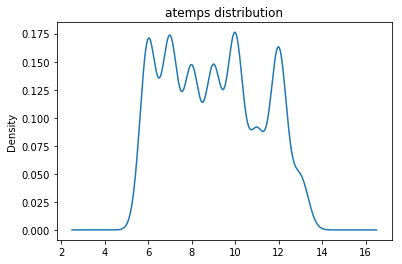

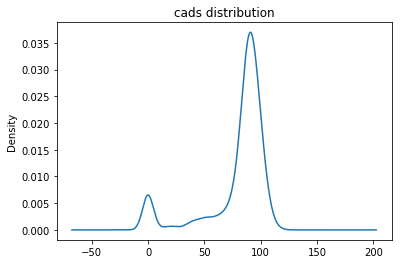

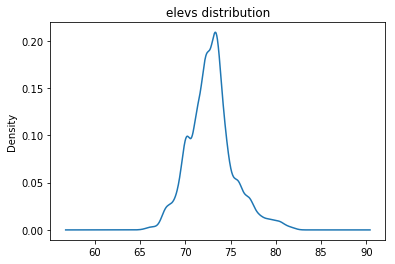

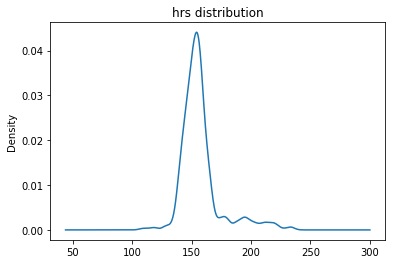

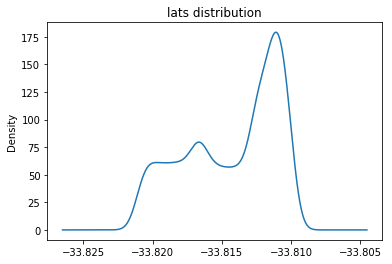

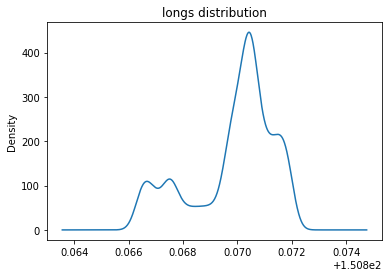

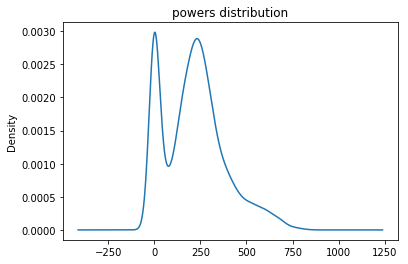

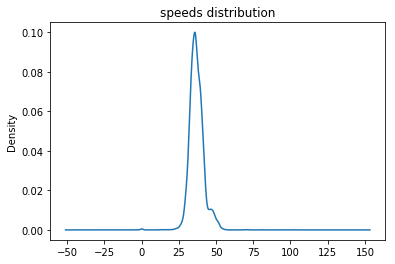

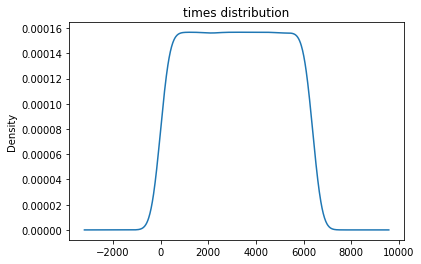

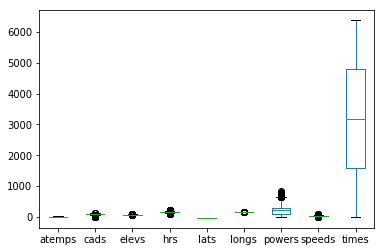

In [8]:
for i, column in enumerate(race1):
    plt.figure(i)
    race1[column].plot.kde()
    plt.title(column+' distribution')
race1.plot.box()
plt.show()

## plot histograms for speed, heartrate, power

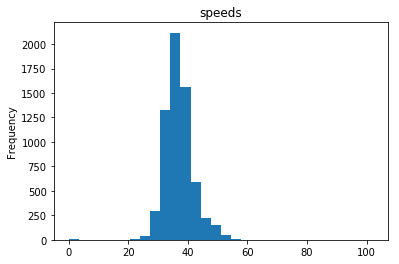

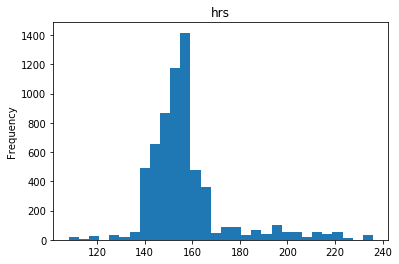

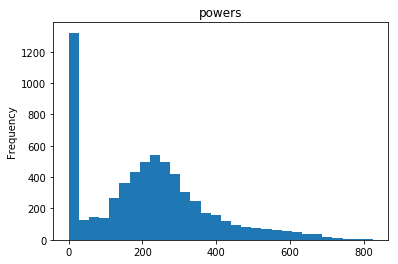

In [69]:
for col in ['speeds','hrs','powers']:
    plt.figure()
    race1[col].plot.hist(bins=30)
    plt.title(col)
plt.show()

plot **scatter matrix** to view possible relationships

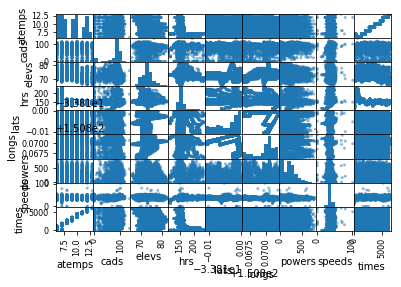

In [70]:
pd.plotting.scatter_matrix(race1)
plt.show()

This plot is not very useful as the individual plots are so small, so we will only **plot speeds, powers and hrs**. We will also quickly **plot atemps vs time** as there seems to be a strong relationship there.

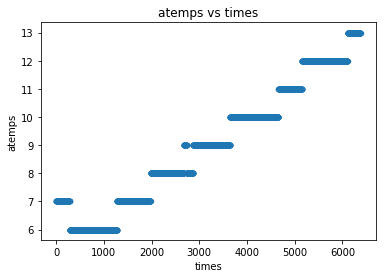

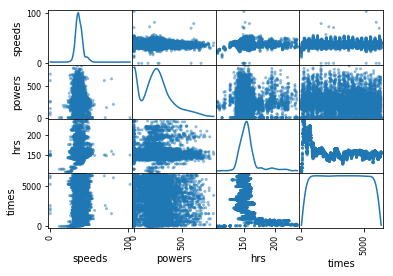

In [11]:
plt.figure(1)
race1.plot.scatter('times','atemps', title='atemps vs times')
plt.figure(2)
pd.plotting.scatter_matrix(race1[['speeds','powers','hrs','times']], diagonal='kde')
plt.show()

there doesnt seem to be any type of correlation between any of these variables, apart from heartrate and time which seems to have started high then calmed down. Lets look closer

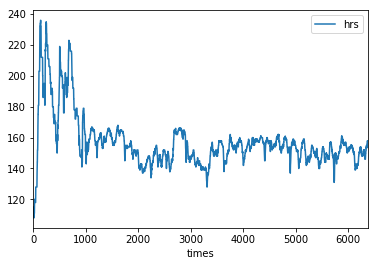

In [12]:
race1.plot('times','hrs')
plt.show()

this effect is less profound when viewed up close. Lets also plot elevation to see if there are any correlations to a specific part of the track

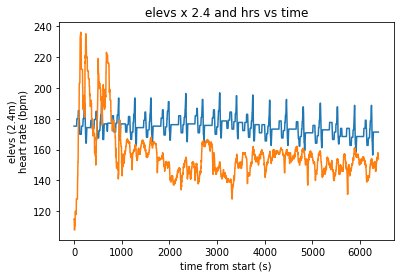

In [13]:
plt.plot(race1['times'].values, race1['elevs'].values*2.4)
plt.plot(race1['times'].values, race1['hrs'].values)
plt.title('elevs x 2.4 and hrs vs time')
plt.ylabel('elevs (2.4m)\nheart rate (bpm)')
plt.xlabel('time from start (s)')
plt.show()

there doesnt seem to be any descernable relationship here. 

removed 65 values.


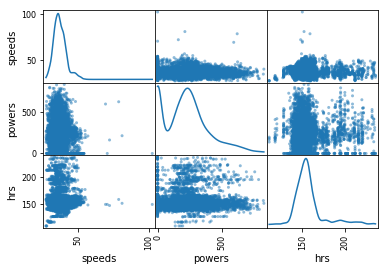

In [14]:
def removed_outlier(df, col, quantile, printout=True):
    rval = df[df[col] < df[col].quantile(quantile)]
    rval = df[df[col] > df[col].quantile(1-quantile)]
    if printout:
        print('removed', len(df)-len(rval), 'values.')
    return rval
    
c_race1 = removed_outlier(race1, 'speeds', .99)
pd.plotting.scatter_matrix(c_race1[['speeds','powers','hrs']], diagonal='kde')
plt.show()

this hasnt improved the situation and it has removed information that we suspect is important (high speeds at the downhill sections)

we will now try to find the number of laps completed! this is a fairly easy task
we will plot the distance from the initial position and the number of waves in the resultant graph is the number of completed laps.

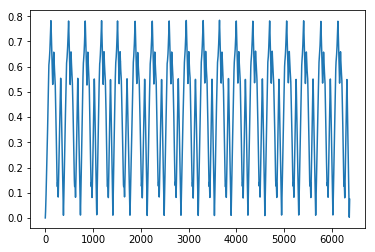

In [77]:
def dists_from_start(df):
    """returns a list of distances from the first point in the dataframe. Dataframe must have columns
    longs, lats, elevs."""
    # lambda function passes first value in df and the argument unpacked to dist.
    # it is then mapped to the nparray of df only using columns longs, lats, elevs
    # (the values required for calculating distance)
    return list(map(lambda x : dist(*df[['longs','lats','elevs']].values[0], *x),
                    df[['longs','lats','elevs']].values))
plt.plot(dists_from_start(race1))
plt.show()

here we can see that there are 18 completed laps as there are 18 'waves'.
just for fun, we can see what a (close) approximation of the track looks like!

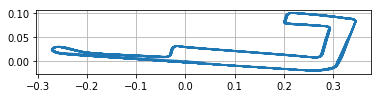

In [16]:
def dist_vec(coord1, coord2):
    la1, lo1, h1 = coord1
    la2, lo2, h2 = coord2
    circumfrance = (6371+(h1+h2)/2)*pi
    dx = (lo2-lo1)*circumfrance*cos(radians(la1+la2))/360
    dy = (la1-la2)*circumfrance/360
    return dx, dy
# similar to map from dists_from_start
vec = list(map(lambda x : dist_vec(x, race1[['lats','longs','elevs']].values[0]),
               race1[['lats','longs','elevs']].values))
plt.subplot(3,1,1) # squash plot to make it closer to a square projection
# there is probably a better way to do this
plt.plot(*list(zip(*vec))[::-1])
plt.grid('on')
plt.show()


# Part 2 - race 2
first, as before import the file and parse its information

In [17]:
root = ET.parse('race2.gpx').getroot()
data = {'lats':[],'longs':[], 'elevs':[]}
for child in root[0][1]:
    data['lats'].append(float(child.get('lat')))
    data['longs'].append(float(child.get('lon')))
    data['elevs'].append(float(child[0].text))
race2 = pd.DataFrame(data)

now we add the speeds and calculate all the averages

Here I assume that the GPS coordinates are recorded at an interval of 1 per second.

In [18]:
speeds = list(map(dist, race2['longs'].values[:-1], race2['lats'].values[:-1], race2['elevs'].values[:-1],
             race2['longs'].values[1:], race2['lats'].values[1:], race2['elevs'].values[1:]))
speeds.insert(0, np.NaN)
speeds = np.array(speeds)*3600
race2['speeds'] = speeds
print('average speed is', str(race2.speeds.mean()) + 'km/h.')

average speed is 37.9520221747km/h.


Now we can check if this is a resonable assumption by **comparing the data in race2 to the data in race1**

In [19]:
dr1 = dists_from_start(race1)
dr2 = dists_from_start(race2)
race1['dstart'] = dr1
race2['dstart'] = dr2

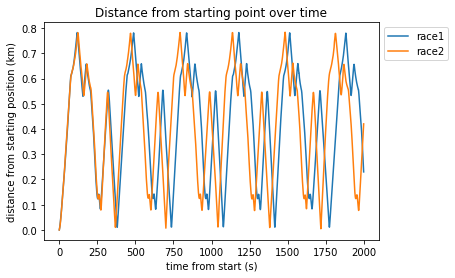

In [20]:
plt.plot(dr1[:2000])
plt.plot(dr2[:2000])
plt.legend(['race1','race2'], bbox_to_anchor=(1,1))
plt.xlabel('time from start (s)')
plt.ylabel('distance from starting position (km)')
plt.title('Distance from starting point over time')
plt.show()

here we can see that the lines match up except the frequency of the line for race2 is higher, meaning the rider in **race 1 is slower then race 2**

## trough detection function

In [21]:
#add a time factor to allow for the next function to work with both datasets
race2['times'] = range(0, len(race2.values))

here we **find peaks and make sure that we have them all** and no more. We could write a function that ensures no peaks are too close to each other, but this dataset is small enough that we can do it visually faster.

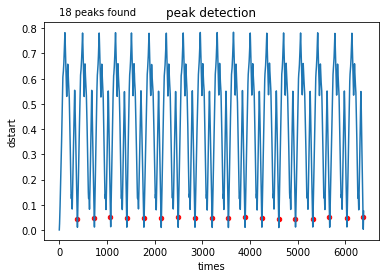

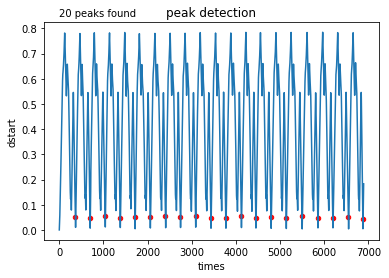

In [22]:
def find_peaks(df, col, cutoff=.03):
    """returns a subset of df that only contains the troughs it detected."""
    # cut off most of the data, the bottom peaks are all we want.
    # for this dataset, the lowest 3% of the datapoints safely includes
    # all the troughs.
    subdf = df[df[col]<df[col].quantile(cutoff)]
    # scipy cwt peaks method
    points = signal.find_peaks_cwt(subdf[col], np.arange(1,2))
    # extract the values from indices
    vals = [subdf.values[x] for x in points]
    # return a healthy dataframe.
    return pd.DataFrame(vals, columns=df.columns.values)


peaks1 = find_peaks(race1, 'dstart')
peaks2 = find_peaks(race2, 'dstart')

# visually check peaks are accurate for race 1
plt.figure(1)
peaks1.plot.scatter('times','dstart', c='r')
plt.text(0,.85, '{} peaks found'.format(len(peaks1)))
plt.plot(race1['times'], race1['dstart'])
plt.title('peak detection')

# visually check peaks are accurate for race 2
plt.figure(2)
peaks2.plot.scatter('times','dstart', c='r')
plt.plot(race2['times'],race2['dstart'])
plt.text(0,.85,'{} peaks found'.format(len(peaks2)))
plt.title('peak detection')
plt.show()

find the lap timestamps and delta times

racer 1 average lap time: 353.83s
racer 2 average lap time: 343.80s


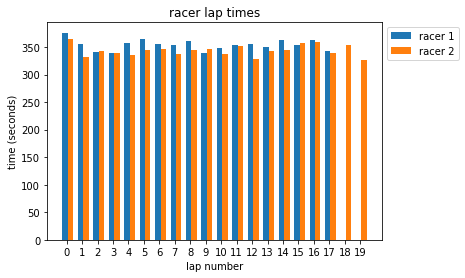

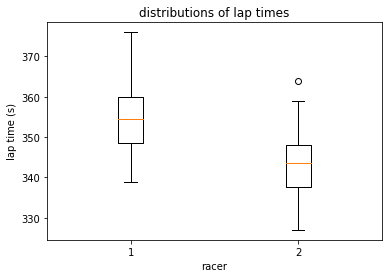

In [23]:
# delta lap times
peaks1['laptimes'] = peaks1['times'].diff().values
peaks2['laptimes'] = peaks2['times'].diff().values

# add first lap times again
peaks1.laptimes.values[0] = peaks1.times.values[0]
peaks2.laptimes.values[0] = peaks2.times.values[0]

# plot bar chart of lap times
fig, ax = plt.subplots(1)
ax.bar(np.arange(0, len(peaks1))-.10, peaks1['laptimes'].values, .35)
ax.bar(np.arange(0, len(peaks2))+.25, peaks2['laptimes'].values, .35)
plt.xticks(range(0,20))
plt.yticks(range(0,400,50))
plt.title('racer lap times')
plt.legend(('racer 1','racer 2'), bbox_to_anchor=(1,1))
plt.xlabel('lap number')
plt.ylabel('time (seconds)')
print('racer 1 average lap time: {:.2f}s\nracer 2 average lap time: {:.2f}s'.format(
      peaks1['laptimes'].mean(),
      peaks2['laptimes'].mean()
))

# plot boxplots of 
plt.figure(2)
plt.boxplot([peaks1['laptimes'].values, peaks2['laptimes'].values])
plt.title('distributions of lap times')
plt.xlabel('racer')
plt.ylabel('lap time (s)')
plt.show()


this bar chart shows that racer 1 had a *longer* time on the majority of the laps that both racers competed in. This is confirmed by the average lap times, which is just under **10 seconds slower for racer 1**. This was plain to see earlier in the plot comparing absolute distance to starting point over time, where the frequency of racer 2 was higher then that of racer 1.

## Racer 2 is faster!

this is the case almost any way you look at it; fastest lap, sum of fastest 10 laps, average lap.

In [24]:
peaks = peaks1, peaks2
for i, p in enumerate(peaks):
    print('Racer',i+1,':')
    v = sorted(p['laptimes'].values)[1:]
    pstring = '{:-<8}:{:->18}'
    print(pstring.format(v[1], 'fastest lap'))
    print(pstring.format(sum(v[:10]), '10 fastest laps'))
    print(pstring.format(round(sum(v)/len(v),2), 'average lap time'))
print()
print('Racer 1 lap breakdown:\n{}\n\nRacer 2 lap breakdown:\n{}'.format(*map(lambda x : str(x.laptimes.describe()), peaks)))

Racer 1 :
341.0---:-------fastest lap
3492.0--:---10 fastest laps
354.71--:--average lap time
Racer 2 :
332.0---:-------fastest lap
3380.0--:---10 fastest laps
344.68--:--average lap time

Racer 1 lap breakdown:
count     18.000000
mean     353.833333
std        9.587062
min      339.000000
25%      348.500000
50%      354.500000
75%      360.000000
max      376.000000
Name: laptimes, dtype: float64

Racer 2 lap breakdown:
count     20.000000
mean     343.800000
std        9.844047
min      327.000000
25%      337.750000
50%      343.500000
75%      348.000000
max      364.000000
Name: laptimes, dtype: float64
